In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import adinilm.functions as F
from adinilm.enumerations import *
from adinilm.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from adinilm.utils import paths_manager as pathsman
from adinilm.io import NilmtkSubsectionExtractor

In [3]:
## Variable declaration for dataset
UKDALE_BUILDING = 1
UKDALE_START_TIME = "2015-01-01"
# END_TIME = "2015-01-15"
UKDALE_END_TIME = "2015-05-01"

FRIDGE_FREEZER = "fridge"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [4]:
info = {
        "subsection" : {
                "building" : UKDALE_BUILDING,
                "start_time" : UKDALE_START_TIME,
                "end_time": UKDALE_END_TIME
        },
        "preprocessing" : {
                "sampling" : {
                        "sample_period" : 2,
                        "resample" : True
                },
                "activation_extension" : {
                        "mode" : "randomizer",
                        "num_full_samples" : 1200000
                },
                "normalization" : {
                        "mode" : "minmax",
                        "scope" : "local"
                }
        },
        "appliances" : [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE],
        "appliance_data" : {
                FRIDGE_FREEZER : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                WASHER_DRYER : {               
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                KETTLE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                DISHWASHER : {
                        "window" : 10,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                },
                MICROWAVE : {
                        "window" : 50,
                        "min" : 0,
                        "max" : 0,
                        "on_power_threshold" : 10,
                }
        }
}

In [5]:
ext = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH, params=info)


c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (2) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (2) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (2) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (2) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [6]:
ext.df.head(6)

,power_series,on_power_threshold,activations
fridge,2015-01-01 00:00:04+00:00 0.0 2015-01-01 0...,50.0,"[[0.0, 0.0, 103.0, 100.0, 97.0, 97.0, 95.0, 94..."
washer dryer,2015-01-01 00:00:00+00:00 0.0 2015-01-01 00...,20.0,"[[10.0, 10.0, 103.0, 103.0, 10.0, 10.0, 10.0, ..."
kettle,2015-01-01 00:00:04+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 565.0, 2347.0, 2350.0, 2365.0, 238..."
dish washer,2015-01-01 00:00:04+00:00 1.0 2015-01-01 00...,10.0,"[[1.0, 1.0, 24.0, 23.0, 24.0, 24.0, 24.0, 6.0,..."
microwave,2015-01-01 00:00:02+00:00 1.0 2015-01-01 00...,200.0,"[[1.0, 1.0, 1632.0, 1623.0, 1619.0, 1612.0, 16..."
site meter,2015-01-01 00:00:00+00:00 138.899994 2015-0...,NaN,NaN


In [7]:
FS = 1          # 1 Hz
DUR = 512       # 512 sec

In [8]:
SAMPLE_LENGTH = int(DUR * FS)

In [9]:
def quantile_filter_2(data, sequence_length, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [10]:
# utils

def match_timeframes(series):
        start_tfs = []
        end_tfs = []
        for tf in series:
                index = tf.index
                start_tfs.append(index[0])
                end_tfs.append(index[-1])
        uniform_start_tf = max(start_tfs)
        uniform_end_tf = min(end_tfs)

        series_c = series.copy()
        for idx, tf in enumerate(series):
                series_c[idx] = tf[uniform_start_tf:uniform_end_tf]

        return series_c

In [11]:
class SubmeterDataframeFormatter:

        def __init__(self, applist: list):
                self.applist = applist

        def format(self, data : pd.DataFrame, *args, **kwargs) -> np.ndarray:
                finder = kwargs.get() if "finder" in kwargs else "power_series"
                data = data.loc[self.applist, finder]

                data = match_timeframes(data)

                p = []
                for r in data:
                        p.append(np.array(r))

                data = np.array(p)
                data[np.isnan(data)] = 0
                return data

        def __call__(self, data, *args, **kwargs):
                return self.format(data, *args, **kwargs)

In [12]:
class QuantileFilterApplier:

        def __init__(self, info, p=50):
                self.info = info
                self.p = p
        
        def filter(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[i,:] = quantile_filter_2(data[i,:], self.info["appliance_data"][app]["window"], p=self.p)
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.filter(data, *args, **kwargs)

In [13]:
class AdaptiveMinMaxScaling:
    
        def __init__(self, info):
                self.info = info

        def normalize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[i,:] = F.adaptive_minmax_scaling(data[i,:])
                
                return data_c

        def __call__(self, data, *args, **kwargs):
                return self.normalize(data, *args, **kwargs)


In [14]:
class OnPowerThresholdBinarizer:
        def __init__(self, info):
                self.info = info
        
        def binarize(self, data, *args, **kwargs):
                apps = self.info["appliances"]
                data_c = data.copy()
                for i, app in enumerate(apps):
                        data_c[i,:] = F.binarization(data[i,:], mode="threshold", threshold=self.info["appliance_data"][app]["on_power_threshold"])
                return data_c
        
        def __call__(self, data, *args, **kwargs):
                return self.binarize(data, *args, **kwargs)

In [15]:
class SubmeterMixer:

        def mix(self, data : np.ndarray, *args, **kwargs):
                return data.sum(axis=0)

        def __call__(self, data, *args, **kwargs):
                return self.mix(data, *args, **kwargs)

In [16]:
formatter = SubmeterDataframeFormatter(applist=ext.params["appliances"])
filterer = QuantileFilterApplier(ext.params)
normalizer = AdaptiveMinMaxScaling(ext.params)
binarizer = OnPowerThresholdBinarizer(ext.params)
mixer = SubmeterMixer()

In [17]:
# Pipeline Workflow
data = formatter(ext.df)
data_i = mixer(data)
data_i = quantile_filter_2(data_i, 20, p=50)
data_i = F.adaptive_minmax_scaling(data_i)
data = filterer(data)
data_p = normalizer(data)
data_s = binarizer(data)
data_p = data_p.T
data_s = data_s.T

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_21136\361044578.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


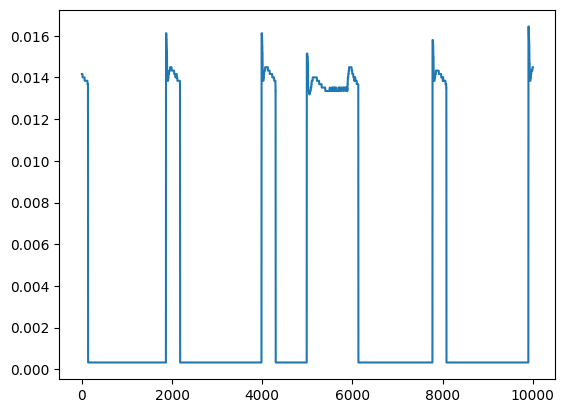

In [18]:
plt.plot(data_i[60000:70000])

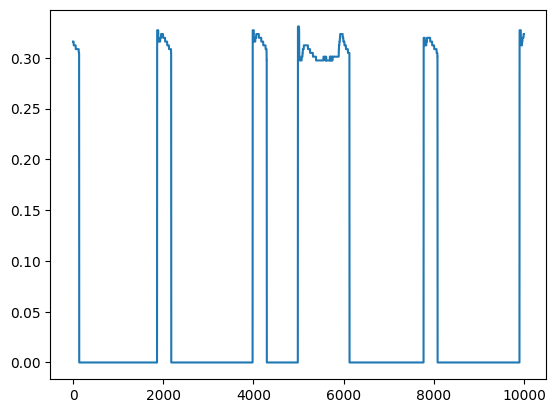

In [19]:
plt.plot(data_p[60000:70000,0])

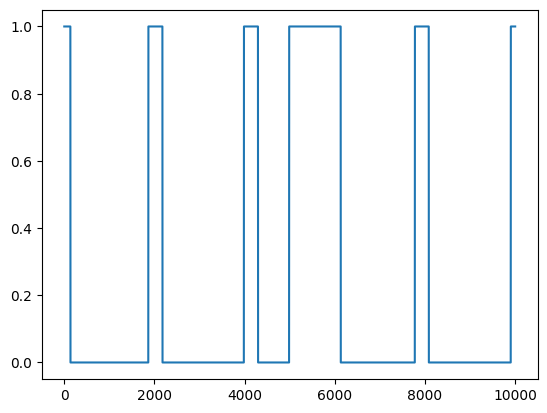

In [20]:
plt.plot(data_s[60000:70000,0])

In [21]:
ProfileHandler.mkdir(pathsman.PROFILES_DIR, exist_ok=True)
prof = DatasetProfile(parent_dir=pathsman.PROFILES_DIR,
                      handler=NILMProjects.UNETNILM.value,
                      dataset_name="ukdale",
                      metadata=info,
                      mode="w")
ProfileHandler.write(data_i, data_i, data_p, data_s, profile=prof, subdir="training")

Full path: C:\Users\MTinaco\Dev\Solutions\cos-algo-nilm\profiles\unetnilm_ukdale_20240725_135400
                